# import modules

In [1]:
import keras
from keras.utils import plot_model,to_categorical
from keras.layers import Dense,LSTM,Bidirectional,TimeDistributed,Conv1D,MaxPool1D,Concatenate,Dropout,BatchNormalization,Add
from keras import Model,Input
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model


from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np

# Load Features

In [19]:
alphabet_set={'0': 0,'a': 1,'e': 2,'g': 3,'i': 4,'n': 5,'o': 6,'r': 7,'u': 8,'v': 9}

In [20]:
alphabet_set={value:key for key,value in alphabet_set.items()}

## One-hot Encoding

# Models


In [2]:
X_gabor = np.load('.\\feature\\X_gabor.npy')
X_gabor_train,X_gabor_val= train_test_split(X_gabor,test_size=0.1,random_state=2019)
X_mfcc= np.load('.\\feature\\X_feature.npy')
y_final= np.load('.\\feature\\y_final.npy')
X_mfcc_train,X_mfcc_val,y_final_train,y_final_val=train_test_split(X_mfcc,y_final,test_size=0.1,random_state=2019)

In [3]:
y_final_train=to_categorical(y_final_train,num_classes=10)
y_final_val=to_categorical(y_final_val,num_classes=10)

In [4]:
y_final_val.shape

(471, 4, 10)

In [5]:
NUM_CLASSES=10
BATCH_SIZE=128
EPOCHS=100
MODEL_SAVE_PATH='.\models\early_merged_final_cnn.h5'

In [6]:
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [14]:
K.clear_session()
inputs1=Input(shape=(35,7),name='inputs_gabor')
x=BatchNormalization()(inputs1)
x = Conv1D(filters = 64, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(x)  #, padding = 'same'
x = MaxPool1D()(x)
#lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
#对于GPU可以使用CuDNNLSTM
lstm_out = Bidirectional(LSTM(128, return_sequences=True,dropout=0.4))(x)
lstm_out = Dropout(0.3)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = MaxPool1D(pool_size=5,strides=4)(attention_mul)
out_gabor = Dense(100, activation='sigmoid',name='gabor')(attention_mul)


inputs2=Input(shape=(50,57),name='inputs_mfcc')
x = BatchNormalization()(inputs2)
x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(x)  #, padding = 'same'
x = Dropout(0.3)(x)
#lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
#对于GPU可以使用CuDNNLSTM
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
lstm_out = Dropout(0.3)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = MaxPool1D(pool_size=43, strides=2)(attention_mul)
out_mfcc = Dense(100, activation='sigmoid',name='mfcc')(attention_mul)

merged_layer= Concatenate(name='heihei')([out_gabor,out_mfcc])
##merged_layer = TimeDistributed(Dense(64))(merged_layer)
merged_layer = Dropout(0.3)(merged_layer)
merged_layer = TimeDistributed(Dense(NUM_CLASSES,activation='softmax'),name='final')(merged_layer)
merged_model = Model([inputs1,inputs2],merged_layer)
merged_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_gabor (InputLayer)       [(None, 35, 7)]      0                                            
__________________________________________________________________________________________________
inputs_mfcc (InputLayer)        [(None, 50, 57)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 35, 7)        28          inputs_gabor[0][0]               
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 57)       228         inputs_mfcc[0][0]                
_______________________________________________________________________________________

In [8]:
NUM_CLASSES=10
BATCH_SIZE=128
EPOCHS=100
MODEL_SAVE_PATH='./models/early_merged_final_cnn.h5'

K.clear_session()
inputs1=Input(shape=(35,7),name='inputs_gabor')
x_1=Conv1D(filters=64,kernel_size=3,padding='same')(inputs1)
x_1=MaxPool1D()(x_1)
x_2=Conv1D(filters=128,kernel_size=8,padding='same')(inputs1)
x_2=MaxPool1D()(x_2)
x_3=Conv1D(filters=256,kernel_size=13,padding='same')(inputs1)
x_3=MaxPool1D()(x_3)
x_4=Conv1D(filters=256,kernel_size=18,padding='same')(inputs1)
x_4=MaxPool1D()(x_4)
x_5=Conv1D(filters=256,kernel_size=25,padding='same')(inputs1)
x_5=MaxPool1D()(x_5)
x=Concatenate()([x_1,x_2,x_3,x_4,x_5])
x=BatchNormalization()(x)
x=Conv1D(filters=64,kernel_size=9)(x)
out_gabor=MaxPool1D(name='gabor')(x)

inputs2=Input(shape=(50,57),name='inputs_mfcc')
x_1=Conv1D(filters=64,kernel_size=3,padding='same')(inputs2)
x_1=MaxPool1D()(x_1)
x_2=Conv1D(filters=128,kernel_size=8,padding='same')(inputs2)
x_2=MaxPool1D()(x_2)
x_3=Conv1D(filters=256,kernel_size=13,padding='same')(inputs2)
x_3=MaxPool1D()(x_3)
x_4=Conv1D(filters=256,kernel_size=18,padding='same')(inputs2)
x_4=MaxPool1D()(x_4)
x_5=Conv1D(filters=256,kernel_size=25,padding='same')(inputs2)
x_5=MaxPool1D()(x_5)
x=Concatenate()([x_1,x_2,x_3,x_4,x_5])
x=BatchNormalization()(x)
x=Conv1D(filters=64,kernel_size=18)(x)
out_mfcc=MaxPool1D(name='mfcc')(x)
#x=Dropout(0.25)(x)
#x=TimeDistributed(Dense(NUM_CLASSES,activation='softmax'))(x)



merged_layer=Concatenate()([out_gabor,out_mfcc])
merged_layer = BatchNormalization()(merged_layer)
merged_layer = TimeDistributed(Dense(64))(merged_layer)
merged_layer = Dropout(0.25)(merged_layer)
merged_layer = TimeDistributed(Dense(NUM_CLASSES,activation='softmax'))(merged_layer)
merged_model = Model([inputs1,inputs2],merged_layer)
merged_model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_gabor (InputLayer)       [(None, 35, 7)]      0                                            
__________________________________________________________________________________________________
inputs_mfcc (InputLayer)        [(None, 50, 57)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 35, 64)       1408        inputs_gabor[0][0]               
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 35, 128)      7296        inputs_gabor[0][0]               
_______________________________________________________________________________________

In [15]:
from keras import optimizers
adam=optimizers.Adam(learning_rate=0.001)

In [16]:

merged_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#plot_model(merged_model,'merged_model_initial.jpg',show_shapes=True)
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_acc',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=merged_model.fit(x=[X_gabor_train,X_mfcc_train],y=y_final_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=([X_gabor_val,X_mfcc_val],y_final_val),
                  callbacks=callback_list)

Epoch 1/100
34/34 [==============================] - 5s 147ms/step - loss: 1.8253 - accuracy: 0.4454 - val_loss: 1.5578 - val_accuracy: 0.5196
Epoch 2/100
34/34 [==============================] - 3s 103ms/step - loss: 1.4723 - accuracy: 0.5389 - val_loss: 1.3030 - val_accuracy: 0.6030
Epoch 3/100
34/34 [==============================] - 4s 112ms/step - loss: 1.2546 - accuracy: 0.5711 - val_loss: 1.0926 - val_accuracy: 0.6088
Epoch 4/100
34/34 [==============================] - 3s 103ms/step - loss: 1.0903 - accuracy: 0.6143 - val_loss: 0.9347 - val_accuracy: 0.6688
Epoch 5/100
34/34 [==============================] - 4s 111ms/step - loss: 0.9692 - accuracy: 0.6545 - val_loss: 0.8375 - val_accuracy: 0.6932
Epoch 6/100
34/34 [==============================] - 4s 106ms/step - loss: 0.8967 - accuracy: 0.6694 - val_loss: 0.7853 - val_accuracy: 0.7139
Epoch 7/100
34/34 [==============================] - 4s 109ms/step - loss: 0.8398 - accuracy: 0.6903 - val_loss: 0.7460 - val_accuracy: 0.7187

## plot_curve

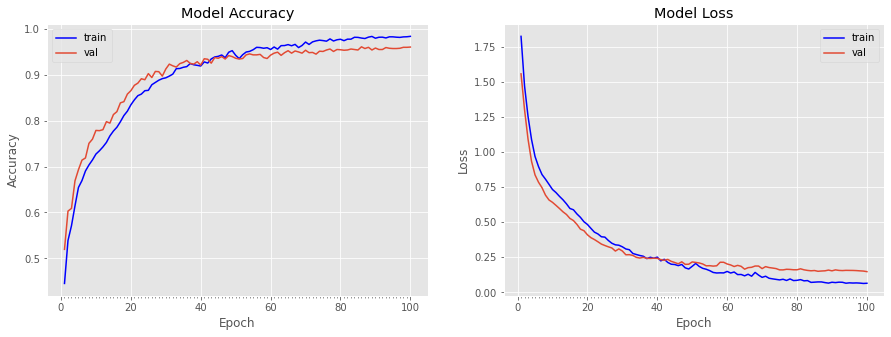

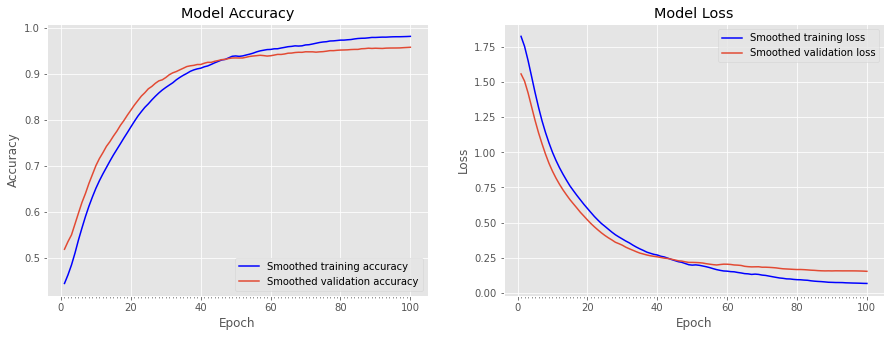

In [17]:
from help import plot_curve,plot_curve_with_smooth
%matplotlib inline 
plot_curve(history)
plot_curve_with_smooth(history)

## confusion_metrix

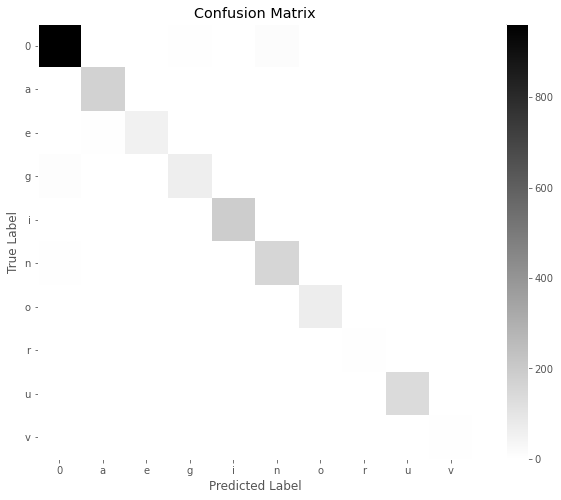

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=merged_model.predict([X_gabor_val,X_mfcc_val])
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_final_val,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
target_names=[alphabet_set[i] for i in range(10)]
def plot_confusion_matrix(confusion_mat):
    plt.figure(figsize=(12,8))
    plt.imshow(confusion_mat,cmap='binary')
    plt.title('Confusion Matrix')
    plt.colorbar()
    labels = target_names
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show() 
plot_confusion_matrix(con_matrix)

## classfication_report

In [22]:
from sklearn.metrics import classification_report
target_names=[alphabet_set[i] for i in range(10)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(10)),target_names=target_names))

              precision    recall  f1-score   support

           0     0.9806    0.9826    0.9816       979
           a     0.9341    0.9714    0.9524       175
           e     0.8983    0.8413    0.8689        63
           g     0.9275    0.8767    0.9014        73
           i     0.9641    0.9592    0.9616       196
           n     0.8971    0.9401    0.9181       167
           o     0.9714    0.9714    0.9714        70
           r     1.0000    0.6667    0.8000         9
           u     0.9580    0.9514    0.9547       144
           v     1.0000    0.5000    0.6667         8

    accuracy                         0.9602      1884
   macro avg     0.9531    0.8661    0.8977      1884
weighted avg     0.9605    0.9602    0.9597      1884



# predict test

In [5]:
merged_model.load_weights(MODEL_SAVE_PATH)

In [6]:
ID = 'person6_time1_group1_ge_4'
temp = np.load('./gabor/'+ID+'.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test1 =[]
test1.append(temp[:35,])
test1 = np.array(test1)

test2 = np.load('./mfcc_data/'+ID+'.npy')
test2 = test2.reshape(1,50,57)


pred=merged_model.predict([test1,test2])

pred=np.argmax(pred,axis=-1)[0]

text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:e


In [8]:
ID = 'person10_time1_group2_zhong_1'
temp = np.load('./gabor/'+ID+'.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test1 =[]
test1.append(temp[:35,])
test1 = np.array(test1)

test2 = np.load('./mfcc_data/'+ID+'.npy')
test2 = test2.reshape(1,50,57)


pred=merged_model.predict([test1,test2])

pred=np.argmax(pred,axis=-1)[0]

text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:ong
